In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [13]:
from sklearn.preprocessing import StandardScaler

In [8]:
df=pd.read_csv("dataset_modified.csv")
df.head(5)

dt        temp  feels_like  pressure  humidity    temp_min  \
0  1672531200  291.642630  303.634593       991      13.0  266.955102   
1  1672534800  298.110529  308.576461      1022      66.0  257.179161   
2  1672538400  306.901877  286.877866       984      53.0  263.838302   
3  1672542000  312.883459  260.983233       998      15.0  260.275475   
4  1672545600  304.110333  257.896054       991      65.0  245.725847   

     temp_max  wind_speed  wind_deg  clouds_all  weather_main  \
0  287.229503    9.803036       128          66  Thunderstorm   
1  290.785585  200.000000       165          24       Drizzle   
2  293.482808   14.681301       306           7       Drizzle   
3  314.995047    8.068081       228          15        Clouds   
4  329.935558    1.946211       151           1       Drizzle   

  weather_description   latitude   longitude  visibility   dew_point  \
0          few clouds  78.780178   -1.732498        7291  286.435469   
1           clear sky   7.808529   62.192429         233  239.293774   
2       light drizzle -40.820393 -117.277940        7270  234.787210   
3           clear sky -80.628369  161.755954        6953  243.060115   
4       light drizzle  -7.494312  -60.130403        6825  281.684305   

   uv_index  temp_Celsius day_of_week  
0  0.586973     18.492630      Sunday  
1  6.287994     24.960529      Sunday  
2  8.619931     33.751877      Sunday  
3  8.731829     39.733459      Sunday  
4  2.691817     30.960333      Sunday

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   500 non-null    int64  
 1   temp                 497 non-null    float64
 2   feels_like           500 non-null    float64
 3   pressure             500 non-null    int64  
 4   humidity             475 non-null    float64
 5   temp_min             500 non-null    float64
 6   temp_max             500 non-null    float64
 7   wind_speed           497 non-null    float64
 8   wind_deg             500 non-null    int64  
 9   clouds_all           500 non-null    int64  
 10  weather_main         498 non-null    object 
 11  weather_description  485 non-null    object 
 12  latitude             500 non-null    float64
 13  longitude            500 non-null    float64
 14  visibility           500 non-null    int64  
 15  dew_point            500 non-null    flo

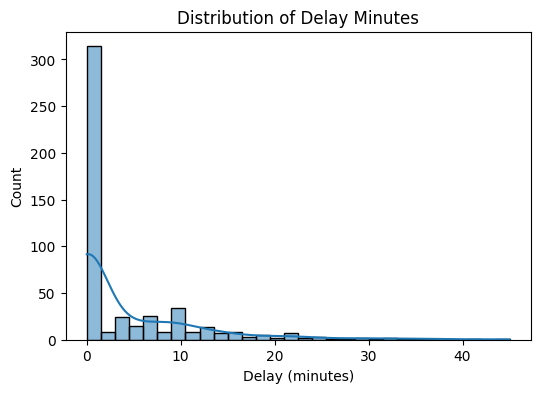

In [57]:
plt.figure(figsize=(6,4))
sns.histplot(df["delay_minutes"], bins=30, kde=True)
plt.title("Distribution of Delay Minutes")
plt.xlabel("Delay (minutes)")
plt.ylabel("Count")
plt.show()

In [14]:
#data cleaning
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].mean())
    else:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mode().iloc[0])

In [ ]:
# robust time parsing & minute differences =====

def _to_datetime(val):
    """
    Parse:
      - numeric -> UNIX seconds
      - string  -> auto parse ('YYYY-mm-dd ...' or 'HH:MM')
    """
    if pd.isna(val):
        return pd.NaT
    # numeric epoch seconds
    if isinstance(val, (int, float, np.integer, np.floating)):
        # If it looks like an epoch second (big), parse with unit='s'
        # else try generic parsing
        try:
            return pd.to_datetime(val, unit="s", errors="coerce")
        except Exception:
            return pd.to_datetime(val, errors="coerce")
    # strings / others
    return pd.to_datetime(val, errors="coerce")


In [16]:
def diff_minutes(a, b):
    """Returns (a - b) in minutes, or np.nan if either cannot be parsed."""
    ta, tb = _to_datetime(a), _to_datetime(b)
    if pd.isna(ta) or pd.isna(tb):
        return np.nan
    return (ta - tb).total_seconds() / 60.0

In [19]:
#create columns needed by formula
needed_cols = {"Act_Dept", "Scheduled_Dept", "Act_Arr", "Scheduled_Arr", "Is_Start_Station"}

In [20]:
if not needed_cols.issubset(df.columns):
    # Base time from dt if present, else build a synthetic timeline
    if "dt" in df.columns:
        base_ts = pd.to_datetime(df["dt"], unit="s", errors="coerce")
        # If some dt are invalid NaT, backfill with a simple sequence
        if base_ts.isna().any():
            base_ts = base_ts.fillna(pd.Timestamp("2025-01-01")) + pd.to_timedelta(np.arange(len(df)), unit="min")
    else:
        base_ts = pd.Timestamp("2025-01-01") + pd.to_timedelta(np.arange(len(df)) * 5, unit="min")

    # Scheduled departures -> snap to 15-min slots
    sched_dep = base_ts.dt.floor("15min")

    # Scheduled travel time between 20–90 minutes
    rng = np.random.default_rng(42)
    sched_travel = rng.integers(20, 91, size=len(df))
    sched_arr = sched_dep + pd.to_timedelta(sched_travel, unit="min")

    # Actual times: add noise (can be early or late)
    dep_noise = rng.normal(loc=3, scale=8, size=len(df)).round()   # mean +3 min
    arr_noise = rng.normal(loc=5, scale=12, size=len(df)).round()  # mean +5 min

    act_dep = sched_dep + pd.to_timedelta(dep_noise, unit="min")
    act_arr = sched_arr + pd.to_timedelta(arr_noise, unit="min")

    # Start-station flag ~30%
    is_start = (rng.random(len(df)) < 0.30).astype(int)

    df["Scheduled_Dept"]   = sched_dep
    df["Scheduled_Arr"]    = sched_arr
    df["Act_Dept"]         = act_dep
    df["Act_Arr"]          = act_arr
    df["Is_Start_Station"] = is_start

In [21]:
# Compute ground-truth delay (minutes)
def compute_delay_minutes(row):
    dep_delta = diff_minutes(row["Act_Dept"], row["Scheduled_Dept"])
    arr_delta = diff_minutes(row["Act_Arr"], row["Scheduled_Arr"])
    if pd.isna(dep_delta) or pd.isna(arr_delta):
        return np.nan

    # Your exact logic:
    if (dep_delta > arr_delta):
        if bool(row["Is_Start_Station"]):
            delay = dep_delta
        else:
            delay = dep_delta - arr_delta
    else:
        delay = 0.0

    return max(delay, 0.0)

In [22]:
df["delay_minutes"] = df.apply(compute_delay_minutes, axis=1)
df = df.dropna(subset=["delay_minutes"]).reset_index(drop=True)


In [23]:
# Build feature matrix X (weather + context only; avoid timing leakage)
candidate_features = [
    "temp", "feels_like", "pressure", "humidity", "temp_min", "temp_max",
    "wind_speed", "wind_deg", "clouds_all", "visibility", "dew_point",
    "uv_index", "temp_Celsius", "latitude", "longitude", "day_of_week",
    "weather_main", "weather_description", "dt"  # keep dt if present (numeric timestamp)
]
feature_cols = [c for c in candidate_features if c in df.columns]

In [24]:
X = df[feature_cols].copy()
y = df["delay_minutes"].astype(float)

In [25]:
#one hot encoding
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
X_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [26]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42
)

In [27]:
#scalling
scaler = StandardScaler(with_mean=False)  # safe for sparse
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [28]:
#linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)
y_pred_lin = lin_reg.predict(X_test_s)

In [35]:
print("=== Linear Regression ===")
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("RMSE:",mean_squared_error(y_test, y_pred_lin))
print("R²:", r2_score(y_test, y_pred_lin))

=== Linear Regression ===
MAE: 4.896024374551059
RMSE: 42.67375164034178
R²: -0.26854196314928


In [36]:
#ridge regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_s, y_train)
y_pred_ridge = ridge.predict(X_test_s)

In [38]:
print("=== Ridge Regression ===")
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", mean_squared_error(y_test, y_pred_ridge))
print("R²:", r2_score(y_test, y_pred_ridge))

=== Ridge Regression ===
MAE: 4.894883869784881
RMSE: 42.60629102835544
R²: -0.2665365941841691


In [39]:
#lasso regression
lasso = Lasso(alpha=0.001, random_state=42, max_iter=5000)
lasso.fit(X_train_s, y_train)
y_pred_lasso = lasso.predict(X_test_s)

In [45]:
print("=== Lasso Regression ===")
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", mean_squared_error(y_test, y_pred_lasso))
print("R²:", r2_score(y_test, y_pred_lasso))

=== Lasso Regression ===
MAE: 4.8947448323876435
RMSE: 42.62279311347932
R²: -0.2670271436825007


In [40]:
#decision tree regressor
dt = DecisionTreeRegressor(max_depth=8, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [46]:
print("=== Decision Tree Regressor ===")
print("MAE:", mean_absolute_error(y_test, y_pred_dt))
print("RMSE:", mean_squared_error(y_test, y_pred_dt))
print("R²:", r2_score(y_test, y_pred_dt))

=== Decision Tree Regressor ===
MAE: 4.849700307522145
RMSE: 50.936961765574004
R²: -0.514178411580678


In [41]:
#random forest regressor
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [47]:
print("=== Random Forest Regressor ===")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

=== Random Forest Regressor ===
MAE: 5.252166666666667
RMSE: 40.522557222222225
R²: -0.20459444774739088


In [42]:
#support vector regressor
svr = SVR(kernel="rbf", C=3.0, epsilon=0.1)
svr.fit(X_train_s, y_train)
y_pred_svr = svr.predict(X_test_s)

In [48]:
print("=== SVR ===")
print("MAE:", mean_absolute_error(y_test, y_pred_svr))
print("RMSE:", mean_squared_error(y_test, y_pred_svr))
print("R²:", r2_score(y_test, y_pred_svr))

=== SVR ===
MAE: 3.8139952093251095
RMSE: 47.32990497384559
R²: -0.40695317995973834


In [50]:
results = []

def add_result(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) 
    r2 = r2_score(y_true, y_pred)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R²": r2})

In [52]:
add_result("Linear Regression", y_test, y_pred_lin)
add_result("Ridge Regression", y_test, y_pred_ridge)
add_result("Lasso Regression", y_test, y_pred_lasso)
add_result("Decision Tree", y_test, y_pred_dt)
add_result("Random Forest", y_test, y_pred_rf)
add_result("SVR", y_test, y_pred_svr)

In [53]:
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n=== Model Comparison ===")
print(results_df.to_string(index=False))


=== Model Comparison ===
            Model      MAE     RMSE        R²
    Random Forest 5.252167 6.365733 -0.204594
 Ridge Regression 4.894884 6.527349 -0.266537
 Ridge Regression 4.894884 6.527349 -0.266537
 Lasso Regression 4.894745 6.528613 -0.267027
 Lasso Regression 4.894745 6.528613 -0.267027
Linear Regression 4.896024 6.532515 -0.268542
Linear Regression 4.896024 6.532515 -0.268542
              SVR 3.813995 6.879673 -0.406953
    Decision Tree 4.849700 7.137014 -0.514178
